# The One Goal For Today

To understand how we can use k-means clustering for image segmentation and image compression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# K-means review

First, select values for your hyperparameters: k and distance function.

1. Pick initial centroids (as random data points).
2. For step in range(max_steps):
   1. Assign each point to its closest centroid.
   2. Pick new centroids using the members in each cluster. If the centroids don't change, then return.

This code below comes from day 21. I made one small change to update_centroids to graciously handle the case where no data ended up in a cluster during a round of clustering.

In [2]:
# Euclidean distance
def distance(a, b):
    subtracted = a-b
    return np.sqrt(np.dot(subtracted.T, subtracted))

# Calculate the distance from each data point to each centroid
def get_distances(item, centroids):
    return [distance(item, centroid) for centroid in centroids]

# Update cluster assignments given a set of centroids
# input: list of data points, initial list of centroids
def update_clusters(data, centroids):
    # initialize clusters
    clusters = {}
    for i in range(len(centroids)):
        # set its cluster members to the empty list
        clusters[i] = []
    # initialize mappings
    mappings = {}
    # for each data point
    for j, datum in enumerate(data):
        # find the index of the centroid with the smallest distance to this data point
        min_cluster_index = np.argmin(get_distances(datum, centroids))
        # add this data point to that centroid's cluster
        clusters[min_cluster_index].append(datum)
        # add mapping
        mappings[j] = min_cluster_index
    return clusters, mappings

# Update the centroids given the data
def update_centroids(clusters, oldcentroids):
    # set centroids to empty list
    centroids = []
    # for each set of data points in a cluster around a single centroid
    for centroidid, data_in_cluster in clusters.items():
        # graciously handle case where no data ended up in a cluster
        if len(data_in_cluster) > 0:
            # new centroid is the mean of that cluster
            centroids.append(np.mean(data_in_cluster, axis=0))
        else:
            centroids.append(oldcentroids[centroidid])
    return centroids

# Measure the inertia
def inertia(data, centroids, clusters):
    sum = 0
    for i in clusters.keys():
        for datum in clusters[i]:
            # calculate the distance squared between each data point and its centroid
            sum += distance(datum, centroids[i])**2
    # average over the data
    return sum / len(data)

This function implements k-means clustering. 

*Can you find the bug?*

In [3]:
def kmeans(data, k, cutoff=1):
    # make some initial centroids
    centroids = np.array([data[x] for x in np.random.choice(np.arange(len(data)), size=k, replace=False)])
    # initialize last_inertia
    last_inertia = -1
    while True:
        # get the clusters for these centroids
        clusters, mappings = update_clusters(data, centroids)
        # calculate the inertia for this clustering
        this_inertia = inertia(data, centroids, clusters)
        # stop when the inertia stops changing very much
        if last_inertia > 0 and abs(last_inertia - this_inertia) < cutoff:
            break
        last_inertia = this_inertia
        # update the centroids
        centroids = update_centroids(clusters, centroids)
    return centroids, clusters, mappings, this_inertia

# K-means for image segmentation and compression

An image is a matrix of pixels. Each pixel can be represented as an array of RGB (red, green, blue) values. So an image is shape $x*y*3$ where 3 is for RGB.

In most pictures, the RGB values in one pixel are likely to be similar to those in the pixels around it. For example, the below picture (from https://vancouver.citynews.ca/2016/11/22/dangers-parking-lot-crashes-ahead-holiday-rush/) has a lot of grey pixels.

If we can identify the common colors (the common RGB values) in a picture, then we can replace the RGB values for each pixel by just centroid RGB values. This in turn allows us to:
* compress the image - we can use the centroid IDs as the pixel's values, and just store the centroid RGB values in a dictionary
* segment the image into regions by color

To do this, we are going to treat the image itself as a dataset. Each row will correspond to a pixel, and the columns will be the RGB values.

## Load a picture

(143, 200, 3)


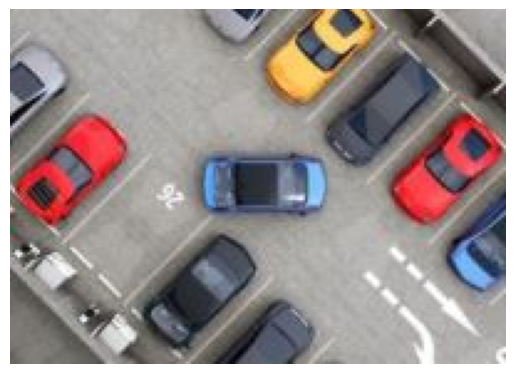

In [4]:
from matplotlib.image import imread

# draw an image using matplotlib with no axes displayed
def display(image):
    fig, ax = plt.subplots()
    ax.axis('off')
    im = ax.imshow(image)

image = imread('data/parking.jpg')
print(image.shape)
display(image)

## Reshape the picture so that it's one long array of pixels

In [5]:
# Reshape the picture so that it's three long arrays, one for each of R/G/B
data = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
print(data.shape)

(28600, 3)


## Find a good value for k

In the absence of a clear intuition, let's try a bunch of possibilities and make an **elbow plot**. 

In [6]:
%%time

# We do k-means clustering for k from 2 to 14 to see what is a good value for k
# Watch how it takes longer and longer (both to converge, and to do one round) as k increases
inertia_by_k = []

for k in range(2, 15, 2):
    print(k)
    _, _, _, last_inertia = kmeans(data, k)
    inertia_by_k.append([k, last_inertia])

2
4
6
8
10
12
14
CPU times: user 2min 11s, sys: 96.6 ms, total: 2min 11s
Wall time: 2min 13s


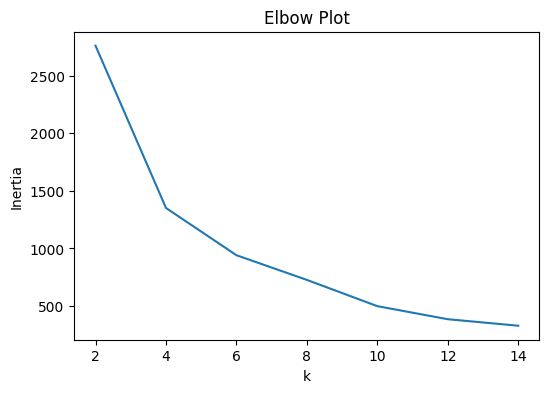

In [7]:
# we make an elbow plot
inertia_by_k = np.array(inertia_by_k)
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.plot(inertia_by_k[:, 0], inertia_by_k[:, 1])
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Plot')
plt.show()

*What value of $k$ would you choose?*

## Re-render the image

Let's replace each pixel in the picture with its corresponding centroid, and then display it!

First we define a *rebuild* function.

In [8]:
# replace each pixel with its corresponding centroid or centroid id
def rebuild(centroids, mappings, idsorvalues='values'):
    res = np.array([mappings[x] for x in sorted(mappings.keys())])
    if idsorvalues == 'values':
        res = np.array([centroids[x] for x in res])
    res = res.round().astype(np.uint8)
    return res

Then we actually rebuild.

In [9]:
# pick k
k = 10
# cluster with this k
centroids, clusters, mappings, last_inertia = kmeans(data, k)

(143, 200, 3)


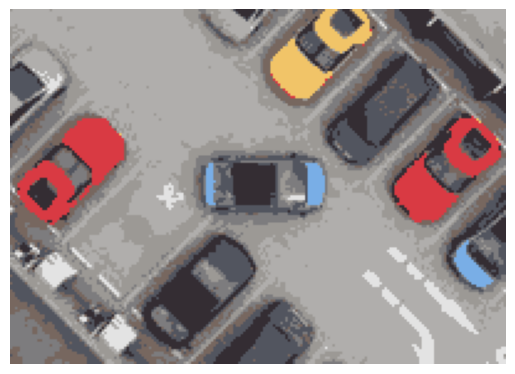

In [10]:
# rebuild the image using the centroid values
output = rebuild(centroids, mappings)
# reshape
output = output.reshape(image.shape[0], image.shape[1], image.shape[2])
# check the output image is a good shape
print(output.shape)
# ensure all pixel values are ints!
output = output.round().astype(int)
# render the image
display(output)

*If you replace each pixel in the above image with an integer (the index of the corresponding centroid), and keep the centroid dictionary, how much smaller is the picture size than the original?*

In [11]:
import sys

compressed = rebuild(centroids, mappings, idsorvalues='ids')
print("Output size: ", sys.getsizeof(output), " bytes")
print("Compressed size: ", sys.getsizeof(compressed), " bytes")
print("Centroid dictionary size: ", sys.getsizeof(centroids), " bytes")

Output size:  686544  bytes
Compressed size:  28712  bytes
Centroid dictionary size:  184  bytes


*If we visualize the compressed image, what segmentation do we see?*

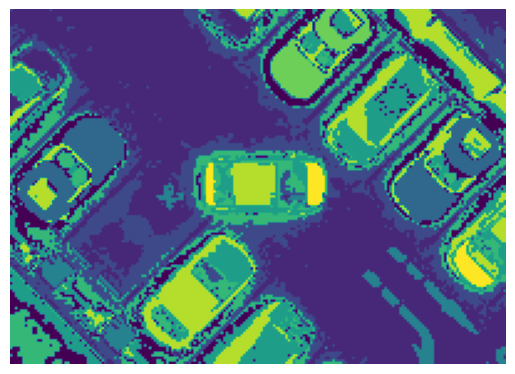

In [12]:
compressed = compressed.reshape(image.shape[0], image.shape[1])
display(compressed)